In [1]:
#### 1对紧挨的两年 1.每年所有城市进行拟合，得到一个标度率；2.每年所有城市按照人口分为4类，得到一个标度率 3.比价两种情况下的标度率的情况
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

In [3]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [4]:
dataPOP=data.iloc[:,3+27*5:21+27*5]###获取POP的数据
dataGDP=data.iloc[:,22+27*5:40+27*5]###获取GDP的数据
dataAmount = data.iloc[:,12:30]###投资金额
dataTimes = data.iloc[:,12+27:30+27]###投资次数

In [5]:
dataTimes[0:1]

,2000总投资次数,2001总投资次数,2002总投资次数,2003总投资次数,2004总投资次数,2005总投资次数,2006总投资次数,2007总投资次数,2008总投资次数,2009总投资次数,2010总投资次数,2011总投资次数,2012总投资次数,2013总投资次数,2014总投资次数,2015总投资次数,2016总投资次数,2017总投资次数
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,0.0


In [6]:
### 获得双对数的值 ，舍掉双对数中的0值###
def get_log3(inv,g,DATA,city,popType):###读取两属性均存在的数据，将两两属性均存在数据的城市保存下来
    y_investment=np.log10(DATA[inv])###当年数据
    y_gdp=np.log10(DATA[g])
    y_investment2=y_investment.fillna(np.infty)
    y_gdp2=y_gdp.fillna(np.infty)
    x1=[]###保存两属性均存在的城市的当年的数据
    y1=[]
    X1=[]###保存两属性均存在的城市的当年的原数据
    Y1=[]
    CITY=[]###保存两属性均存在的城市名
    typePop=[]###保存分类
    for xi in range(len(y_investment2)):
        if y_investment2[xi]==-float('Inf') or y_investment2[xi]==float('Inf') or y_gdp2[xi]==-float('Inf') or y_gdp2[xi]==float('Inf'):
#             print('inf...')
            continue
#         elif xi>-4:
        else:
            x1.append(y_investment2[xi])
            y1.append(y_gdp2[xi])
            X1.append(DATA[inv][xi])
            Y1.append(DATA[g][xi])
            CITY.append(city[xi])
            typePop.append(popType[xi])###保存分类
    return(x1,y1,CITY,X1,Y1,typePop)

In [7]:
### 6.最小二乘拟合
from scipy.optimize import leastsq  ##引入最小二乘法算法
from sklearn.metrics import r2_score
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y
def pic(yt1,yt2):
#     yt1=yt[0]
#     yt2=yt[1]
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(yt1)
    Yi=np.array(yt2)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点

    #读取结果
    k,b=Para[0]
    y = [k*x+b for x in yt1]
    k1=round(k, 2)
    return(k1,b)


In [8]:
pop17 = data['2017Pop'].values
data['popType']=pop17
for i in range(len(pop17)):
        if pop17[i] < 100:
            data['popType'][i]=1###小城市
        elif pop17[i] < 550:
            data['popType'][i]=2###
        else:
            data['popType'][i]=3###特大城市

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
popType = data['popType'].values
Aβ=[]###保存值拟合两年都有数据的城市的标度律变化
Tβ=[]
Gβ=[]
for i in range(18):
    ### amount
    YT_A = get_log3(pop[i],investment[i],data,city,popType)
    KB1_A = pic(YT_A[0],YT_A[1])[0]
    Aβ.append(KB1_A)
    
    ###times
    YT_T = get_log3(pop[i],inv_times[i],data,city,popType)
    KB1_T = pic(YT_T[0],YT_T[1])[0]
    Tβ.append(KB1_T)
    
    ###GDP
    YT_G = get_log3(pop[i],gdp[i],data,city,popType)
    KB1_G = pic(YT_G[0],YT_G[1])[0]
    Gβ.append(KB1_G)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [10]:
def getInter(Pop,GDP,i,data,city,popType):##i代表第几年
    YT = get_log3(Pop[i],GDP[i],data,city,popType)
    ###得到城市人口
    city2 = YT[2]###两年都存在的城市的名字
    dfInter=pd.DataFrame()
    dfInter['gdp'] = YT[1]
    dfInter['pop'] = YT[0]
    
    ###新增规模分类一列
    dfInter['popType']=YT[5]###城市类别
            
    listType=[1,2,3]
    DATA=[]
    avgAll = []
    for li in listType:
        dat=dfInter[dfInter['popType'].isin([li])]
        DATA.append(dat)
        cols = dat.shape[0]###行数
        D = dat.iloc[0:cols,:]###更新行号
        dat.index=[np.arange(0,cols)]
        avg = dat.mean()###得到均值
        avgAll.append(avg)###得到每一类的均值
    dfAvg=pd.DataFrame(avgAll)
    return(dfAvg)

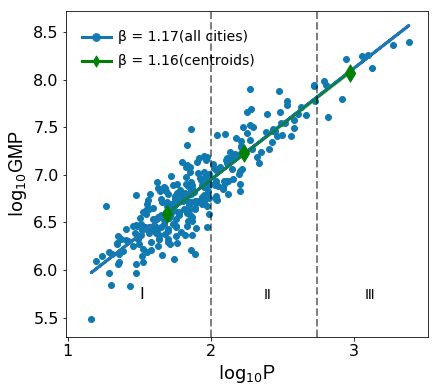

In [13]:
fig=plt.figure(figsize=(6.5,6))
ax=fig.add_subplot(111)
YT = get_log3(pop[15],gdp[15],data,city,popType)
dfAvg_G=getInter(pop,gdp,15,data,city,popType)
dfAvg_G2=getInter(pop,gdp,16,data,city,popType)
bb=pic(dfAvg_G['pop'].values,dfAvg_G['gdp'].values)
aa=pic(YT[0],YT[1])
# YT[0]

plt.plot(YT[0],[aa[0]*xx+aa[1] for xx in YT[0]],alpha=1,linewidth=3, zorder=1)###原点拟合
plt.plot(dfAvg_G['pop'],[bb[0]*xx+bb[1] for xx in dfAvg_G['pop']],linewidth=3,alpha=0.55,color='green', zorder=1)###平均值

font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 18,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 14,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('$\log_{10}$'+'P',font2)
plt.ylabel('$\log_{10}$'+'GMP',font2)

plt.plot([1.1,1.3],[8.45,8.45],color='#107ab0',linewidth=3)###为了显示label
plt.plot([1.1,1.3],[8.2,8.2],color='green',linewidth=3)
plt.scatter(1.2,8.45,s=60)
plt.scatter(1.2,8.2,marker='d',color='green',s=60)
plt.text(1.35,8.41,'β = {}'.format("%.2f" % aa[0])+'(all cities)',size=14)
plt.text(1.35,8.15,'β = {}'.format("%.2f" % bb[0])+'(centroids)',size=14)

plt.scatter(YT[0],YT[1],color='#107ab0',alpha=1)###原点
plt.scatter(dfAvg_G['pop'],dfAvg_G['gdp'],marker='d',s=150,color='green',alpha=1, zorder=2)
plt.axvline(x=np.log10(100), c="black", ls="--", lw=2,alpha=0.5)###画出分类线
plt.axvline(x=np.log10(550), c="black", ls="--", lw=2,alpha=0.5)
# plt.axvline(x=np.log10(1000), c="black", ls="--", lw=2,alpha=0.5)
plt.text(1.5,5.7,'Ⅰ',size=16)
plt.text((2+np.log10(550))/2,5.7,'Ⅱ',size=14)
plt.text((np.log10(550)+3.4)/2,5.7,'Ⅲ',size=14)
ax.set_xticks([1,2,3])
# plt.savefig('E:/vcdata/pic/picSC/Fig4_b.pdf', bbox_inches='tight')#保存图片
plt.savefig('E:/0论文/0picture/5_4.png',dpi=500, bbox_inches='tight')

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


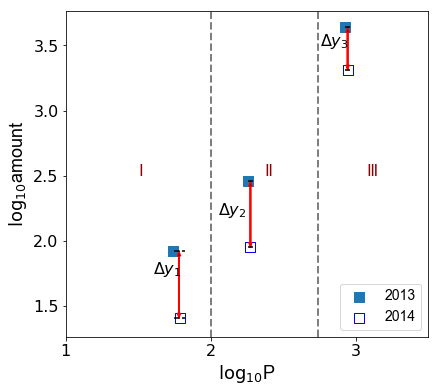

In [14]:
#### 两年变化的示意图
from matplotlib.ticker import FuncFormatter   ### 今天的主角
fig = plt.figure(figsize=(6.5,6))
ax = fig.add_subplot(111)
def formatnum(x, pos):
    return '$%.0f$' % x
# YT = get_log3(pop[15],gdp[15],data,city)
dfAvg_1G=getInter(pop,investment,13,data,city,popType)
dfAvg_1G2=getInter(pop,investment,14,data,city,popType)

font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 18,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 14,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('$\log_{10}$'+'P',font2)
plt.ylabel('$\log_{10}$'+'amount',font2)
formatter = FuncFormatter(formatnum)
plt.scatter(dfAvg_1G['pop'],dfAvg_1G['gdp'],marker='s',s=100,label='2013')
plt.scatter(dfAvg_1G2['pop'],dfAvg_1G2['gdp'],marker='s',s=100,c='',edgecolors='blue',label='2014')
plt.plot([dfAvg_1G['pop'][0]+0.01,2*(dfAvg_1G2['pop'][0]-0.01)-dfAvg_1G['pop'][0]],[dfAvg_1G['gdp'][0],dfAvg_1G['gdp'][0]],linestyle='--',color='black')###画出虚线
plt.plot([dfAvg_1G['pop'][0]+0.01,2*(dfAvg_1G2['pop'][0]-0.01)-dfAvg_1G['pop'][0]],[dfAvg_1G2['gdp'][0],dfAvg_1G2['gdp'][0]],linestyle='--',color='black')
plt.plot([dfAvg_1G['pop'][1],2*(dfAvg_1G2['pop'][1])-dfAvg_1G['pop'][1]],[dfAvg_1G['gdp'][1],dfAvg_1G['gdp'][1]],linestyle='--',color='black')
plt.plot([dfAvg_1G['pop'][1],2*(dfAvg_1G2['pop'][1])-dfAvg_1G['pop'][1]],[dfAvg_1G2['gdp'][1],dfAvg_1G2['gdp'][1]],linestyle='--',color='black')
plt.plot([dfAvg_1G['pop'][2],2*(dfAvg_1G2['pop'][2])-dfAvg_1G['pop'][2]],[dfAvg_1G['gdp'][2],dfAvg_1G['gdp'][2]],linestyle='--',color='black')
plt.plot([dfAvg_1G['pop'][2],2*(dfAvg_1G2['pop'][2])-dfAvg_1G['pop'][2]],[dfAvg_1G2['gdp'][2],dfAvg_1G2['gdp'][2]],linestyle='--',color='black')

ax.arrow(dfAvg_1G2['pop'][0]-0.01, dfAvg_1G['gdp'][0],0,dfAvg_1G2['gdp'][0]-dfAvg_1G['gdp'][0],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025) # 增加的长度包含箭头部分
ax.arrow(dfAvg_1G2['pop'][0]-0.01, dfAvg_1G2['gdp'][0],0,dfAvg_1G['gdp'][0]-dfAvg_1G2['gdp'][0],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025)
ax.arrow(dfAvg_1G2['pop'][1], dfAvg_1G['gdp'][1],0,dfAvg_1G2['gdp'][1]-dfAvg_1G['gdp'][1],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025) # 增加的长度包含箭头部分
ax.arrow(dfAvg_1G2['pop'][1], dfAvg_1G2['gdp'][1],0,dfAvg_1G['gdp'][1]-dfAvg_1G2['gdp'][1],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025)
ax.arrow(dfAvg_1G2['pop'][2], dfAvg_1G['gdp'][2],0,dfAvg_1G2['gdp'][2]-dfAvg_1G['gdp'][2],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025) # 增加的长度包含箭头部分
ax.arrow(dfAvg_1G2['pop'][2], dfAvg_1G2['gdp'][2],0,dfAvg_1G['gdp'][2]-dfAvg_1G2['gdp'][2],width=0.007,length_includes_head=True,fc='darkred',ec='red',head_width=0.025)

plt.text(1.6, 1.75, '$\Delta {}$'.format('y_1'),size=16)
plt.text(2.05, 2.2, '$\Delta {}$'.format('y_2'),size=16)
plt.text(2.75, 3.5, '$\Delta {}$'.format('y_3'),size=16)
plt.xlim(1,3.5)
plt.legend(prop=font1,loc='lower right')
ax.set_xticks([1,2,3])

plt.axvline(x=np.log10(100), c="black", ls="--", lw=2,alpha=0.5)###画出分类线
plt.axvline(x=np.log10(550), c="black", ls="--", lw=2,alpha=0.5)
plt.text(1.5,2.5,'Ⅰ',size=16,color='darkred')
plt.text((2+np.log10(550))/2,2.5,'Ⅱ',size=16,color='darkred')
plt.text((np.log10(550)+3.4)/2,2.5,'Ⅲ',size=16,color='darkred')
# plt.savefig('E:/vcdata/pic/picSC/Fig4_c.pdf', bbox_inches='tight')#保存图片
plt.savefig('E:/0论文/0picture/5_6.png',dpi=500, bbox_inches='tight')

In [15]:
###  得到两年均值的差，并对其拟合,根据两年人口均值和y轴变化值
def picDeltaY4(y1,y2,x1,x2):
    from matplotlib.ticker import FuncFormatter ###设置为整数
    k=[]
    b=[]
    x1=[1,2,3]
    detaX1 = [(x2[i]+x1[i])/2 for i in range(len(x1))]###得到两年均值之差
    detaY1 = [y2[i]-y1[i] for i in range(len(y1))]###得到两年均值之差
    k = pic(detaX1,detaY1)[0]
    b = pic(detaX1,detaY1)[1]
    return(k,b,detaX1,detaY1)

In [16]:
###得到2000-2017年的k值
kA3=[]###根据均值的变化值得到的标度率
kT3=[]
kG3=[]
for i in range(17):
    dfAvg_1A=getInter(pop,investment,i,data,city,popType)
    dfAvg_1A2=getInter(pop,investment,i+1,data,city,popType)
    kA3.append(picDeltaY4(dfAvg_1A['gdp'],dfAvg_1A2['gdp'],dfAvg_1A['pop'],dfAvg_1A2['pop'])[0])
    
    dfAvg_1T=getInter(pop,inv_times,i,data,city,popType)
    dfAvg_1T2=getInter(pop,inv_times,i+1,data,city,popType)
    kT3.append(picDeltaY4(dfAvg_1T['gdp'],dfAvg_1T2['gdp'],dfAvg_1T['pop'],dfAvg_1T2['pop'])[0])
    
    dfAvg_1G=getInter(pop,gdp,i,data,city,popType)
    dfAvg_1G2=getInter(pop,gdp,i+1,data,city,popType)
    kG3.append(picDeltaY4(dfAvg_1G['gdp'],dfAvg_1G2['gdp'],dfAvg_1G['pop'],dfAvg_1G2['pop'])[0])

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [17]:
beltaClass_A = []###记录根据每组平均人口-gdp/amount/times拟合得到的标度律，相邻两年每年均值都拟合，再求两年拟合值之差
beltaClass_T = []
beltaClass_G = []
for i in range(18):
    yt1_A=getInter(pop,investment,i,data,city,popType)['pop'].values
    yt2_A=getInter(pop,investment,i,data,city,popType)['gdp'].values
    beltaClass_A.append(pic(yt1_A,yt2_A)[0])
    
    yt1_T=getInter(pop,inv_times,i,data,city,popType)['pop'].values
    yt2_T=getInter(pop,inv_times,i,data,city,popType)['gdp'].values
    beltaClass_T.append(pic(yt1_T,yt2_T)[0])
    
    yt1_G=getInter(pop,gdp,i,data,city,popType)['pop'].values
    yt2_G=getInter(pop,gdp,i,data,city,popType)['gdp'].values
    beltaClass_G.append(pic(yt1_G,yt2_G)[0])

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [18]:
dfNH = pd.DataFrame()
dfNH['belt_A']=beltaClass_A
dfNH['belt_T']=beltaClass_T
dfNH['belt_G']=beltaClass_G
dfNH['ALL_A']=Aβ
dfNH['ALL_T']=Tβ
dfNH['ALL_G']=Gβ

In [84]:
dfNH.to_excel('E:/vcdata/pic/picSC/betaK.xlsx')#####记录按照质心拟合和城市标度律

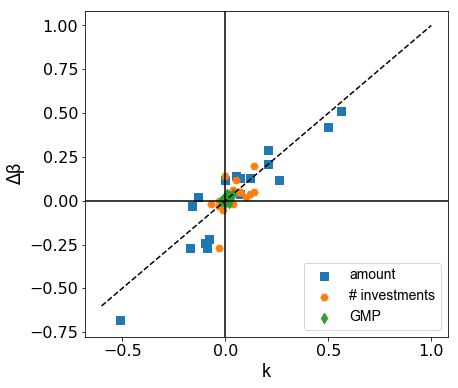

In [20]:
### 正确的 查看所有城市相邻两年标度率的变化 和 所有城市相邻两年的均值之差得到的标度率 
x=np.arange(0,18)
plt.figure(figsize=(6.5,6))
deltaβ_A = [Aβ[X+1]-Aβ[X] for X in range(17)]###得到两年的变化值
deltaβ_T = [Tβ[X+1]-Tβ[X] for X in range(17)]
deltaβ_G = [Gβ[X+1]-Gβ[X] for X in range(17)]
plt.scatter(kA3,deltaβ_A,label='amount',marker='s',s=55)
plt.scatter(kT3,deltaβ_T,label='# investments',marker='H',s=55)
plt.scatter(kG3,deltaβ_G,label='GMP',marker='d',s=55)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 18,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 14,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('k',font2)
plt.ylabel('$\Delta$'+'β',font2)
plt.legend(prop=font1)
plt.ylabel('Δβ',font2)
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
plt.plot([-0.6,0,1],[-0.6,0,1],color='black',linestyle='--')
# plt.savefig('E:/vcdata/pic/picSC/Fig4_d.pdf', bbox_inches='tight')#保存图片
plt.savefig('E:/0论文/0picture/5_7.png',dpi=500, bbox_inches='tight')

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


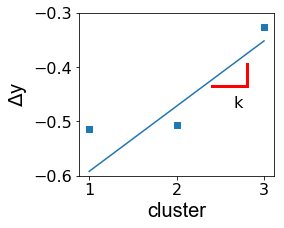

In [21]:
###得到2Δy和k的示意图
i=13
from matplotlib.ticker import FuncFormatter ###设置为整数
fig = plt.figure(figsize=(3.5,3))
ax1 = fig.add_subplot(111)
x=np.arange(1,4)
x2=np.arange(1,5)
dfAvg_1A=getInter(pop,investment,i,data,city,popType)
dfAvg_1A2=getInter(pop,investment,i+1,data,city,popType)
ka = picDeltaY4(dfAvg_1A['gdp'],dfAvg_1A2['gdp'],dfAvg_1A['pop'],dfAvg_1A2['pop'])###得到两年的拟合值和差值
plt.scatter(x,ka[3],marker='s')
plt.plot(x,[(ka[0]*xx+ka[1]) for xx in x])
font2 = {'family' : 'Arial','weight' : 'normal','size' : 20}
font1 = {'family' : 'Arial','weight' : 'normal','size' : 16}
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('cluster',font2)
plt.ylabel('$\Delta$'+'y',font2)
plt.plot([2.8,2.8],[-0.465+0.03,-0.465+0.07],color='red',linewidth=3)
plt.plot([2.4,2.8],[-0.465+0.03,-0.465+0.03],color='red',linewidth=3)
plt.text(2.65, -0.475, 'k',size=16)
# plt.axvline(x=1, c="black", ls="--", lw=2,alpha=0.5)###画出分类线
# plt.axvline(x=2, c="black", ls="--", lw=2,alpha=0.5)
# plt.axvline(x=3, c="black", ls="--", lw=2,alpha=0.5)
plt.ylim(-0.6,-0.3)
ax1.set_xticks([1,2,3])
# plt.savefig('E:/vcdata/pic/picSC/Fig4_c2.pdf', bbox_inches='tight')#保存图片
plt.savefig('E:/0论文/0picture/5_6b.png',dpi=500, bbox_inches='tight')

In [22]:
########### 所有数据拟合得到的标度律和利用质心得到的标度律##########

In [23]:
len(Aβ)

18

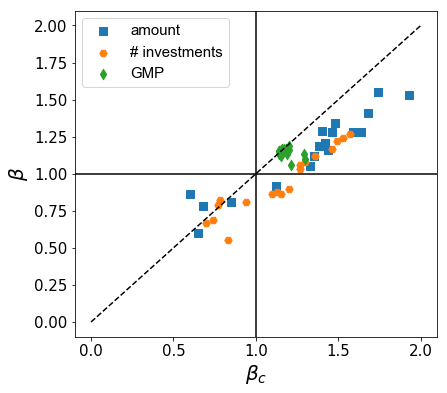

In [24]:
### 正确的 查看所有城市相邻两年标度率的变化 和 所有城市相邻两年的均值之差得到的标度率 
year=np.arange(2000,2018)
plt.figure(figsize=(6.5,6))
plt.scatter(beltaClass_A,Aβ,label='amount',marker='s',s=55)
plt.scatter(beltaClass_T,Tβ,label='# investments',marker='H',s=55)
plt.scatter(beltaClass_G,Gβ,label='GMP',marker='d',s=55)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 20,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 15,
    }
plt.tick_params(labelsize=15) #刻度字体大小13
plt.xlabel('$β_c$',font2)
plt.ylabel('$β$',font2)
plt.legend(prop=font1)
plt.axhline(y=1, color='black', linestyle='-')
plt.axvline(x=1, color='black', linestyle='-')
plt.plot([0,1,2],[0,1,2],color='black',linestyle='--')
# plt.savefig('E:/vcdata/pic/picSC/Fig4_d.pdf', bbox_inches='tight')#保存图片
plt.savefig('E:/0论文/0picture/5_5.png',dpi=500, bbox_inches='tight')

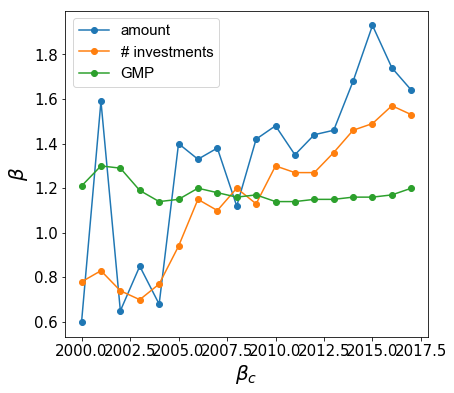

In [89]:
### 正确的 查看所有城市相邻两年标度率的变化 和 所有城市相邻两年的均值之差得到的标度率 
year=np.arange(2000,2018)
plt.figure(figsize=(6.5,6))
plt.plot(year,beltaClass_A,label='amount',marker='o')
plt.plot(year,beltaClass_T,label='# investments',marker='o')
plt.plot(year,beltaClass_G,label='GMP',marker='o')
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 20,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 15,
    }
plt.tick_params(labelsize=15) #刻度字体大小13
plt.xlabel('$β_c$',font2)
plt.ylabel('$β$',font2)
plt.legend(prop=font1)
# plt.axhline(y=1, color='black', linestyle='-')
# plt.axvline(x=1, color='black', linestyle='-')
# plt.plot([0,1,2],[0,1,2],color='black',linestyle='--')
# plt.savefig('E:/vcdata/pic/picSC/Fig4_d.pdf', bbox_inches='tight')#保存图片